In [1]:
import numpy as np
from scipy.optimize import minimize
import fixed_income_derivatives as fid
import matplotlib.pyplot as plt
from numpy.polynomial.hermite import hermfit, hermval
import copy

## **Curve Fitting Exam Prep**

In [3]:
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.03478}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03743},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03871},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03989},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04098},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.04198},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.04289},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.04374},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.04452},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.04524}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.04377, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04625, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.04777, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.04875, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.04992, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05081, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05148, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05181, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05211, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market

### a) Fitting the ZCB term structure

In [4]:
# interpolation_options = {"method": "linear"}
interpolation_options = {"method":"hermite","degree":3}

T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = interpolation_options)
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_fit,R_fit,interpolation_options = interpolation_options,resolution = 1)

### Plotting the par swap rate curve

In [5]:
T_swap = np.array([i for i in range(1,31)])
R_swap, S_swap = np.zeros([len(T_swap)]), np.zeros([len(T_swap)])
for i, maturity in enumerate(T_swap):
    S_swap[i] = fid.zcb_to_accrual_factor(0,T_swap[i],"semiannual",T_inter,p_inter)
    R_swap[i] = fid.zcb_to_par_swap_rate(0,T_swap[i],"semiannual",T_inter,p_inter)

### b) Risk management of a swap position

In [6]:
# DVO1 when bumping one point
idx_swap, T_bump, size_bump = 15, 2, 0.0001
R_inter_bump, p_inter_bump = fid.spot_rate_bump(T_bump,size_bump,T_inter,R_inter,p_inter)
S_swap_bump = fid.zcb_to_accrual_factor(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
DV01 = (R_swap_bump-data[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for the swap with maturity: {data[idx_swap]['maturity']} when bumping spot rate at T: {T_bump} by {10000*size_bump} bps is {10000*DV01} bps")

DV01 for the swap with maturity: 10 when bumping spot rate at T: 2 by 1.0 bps is 0.05252762780880708 bps


In [8]:
# DV01 when bumping entire spot rate curve
idx_swap, size_bump = 15, -0.0001
R_inter_bump, p_inter_bump = fid.spot_rate_bump(T_inter,size_bump,T_inter,R_inter,p_inter)
S_swap_bump = fid.zcb_to_accrual_factor(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
DV01 = (R_swap_bump-data[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for the swap with maturity: {data[idx_swap]['maturity']} when bumping entire spot rate curve is {10000*DV01} bps")

DV01 for the swap with maturity: 10 when bumping entire spot rate curve is -7.939453073126287 bps


In [9]:
# DV01 for bumping one of the swaps
idx_swap, idx_bump, size_bump = 15, 15, -0.0001
p_inter_bump, R_inter_bump, f_inter_bump, T_inter_bump, data_bump = fid.market_rate_bump(idx_bump,size_bump,data,interpolation_options = interpolation_options,resolution = 1)
S_swap_bump = fid.zcb_to_accrual_factor(0,data_bump[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0,data_bump[idx_swap]["maturity"],"semiannual",T_inter_bump,p_inter_bump)
DV01 = (R_swap_bump-data[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for the swap with maturity: {data[idx_swap]['maturity']} when bumping the swap with maturity: {data[idx_bump]['maturity']} is {10000*DV01} bps")

DV01 for the swap with maturity: 10 when bumping the swap with maturity: 10 is -7.858076634732509 bps


### c) PnL of existing positions

In [10]:
T_pos, R_pos = 6, 0.048
swaption_price = 38  # price in bps
S_swap_pos = fid.zcb_to_accrual_factor(0,T_pos,"semiannual",T_inter,p_inter)
R_swap_pos = fid.zcb_to_par_swap_rate(0,T_pos,"semiannual",T_inter,p_inter)
PnL = (R_swap_pos-R_pos)*S_swap_pos
print(f"6Y par swap rate: {R_swap_pos}, S_swap: {S_swap_pos}, PnL of position in 7Y payer swap after one year: {10000*PnL} in bps.")
print(f"Market value of payer swaption now at exercise: {10000*PnL}, PnL of position in swaption: {10000*PnL-swaption_price}.")

6Y par swap rate: 0.04940925537853355, S_swap: 5.17113405100513, PnL of position in 7Y payer swap after one year: 72.87448474496964 in bps.
Market value of payer swaption now at exercise: 72.87448474496964, PnL of position in swaption: 34.874484744969635.


In [11]:
T_set, T_mat, R_pos = 3, 8, 0.051
S_swap_pos = fid.zcb_to_accrual_factor(T_set,T_mat,"semiannual",T_inter,p_inter)
R_swap_pos = fid.zcb_to_par_swap_rate(T_set,T_mat,"semiannual",T_inter,p_inter)
PnL = (R_pos - R_swap_pos)*S_swap_pos
print(f"3Y5Y forward par swap rate: {R_swap_pos}, PnL of position in : {10000*PnL}.")

3Y5Y forward par swap rate: 0.05323765752250031, PnL of position in : -84.6288422797591.


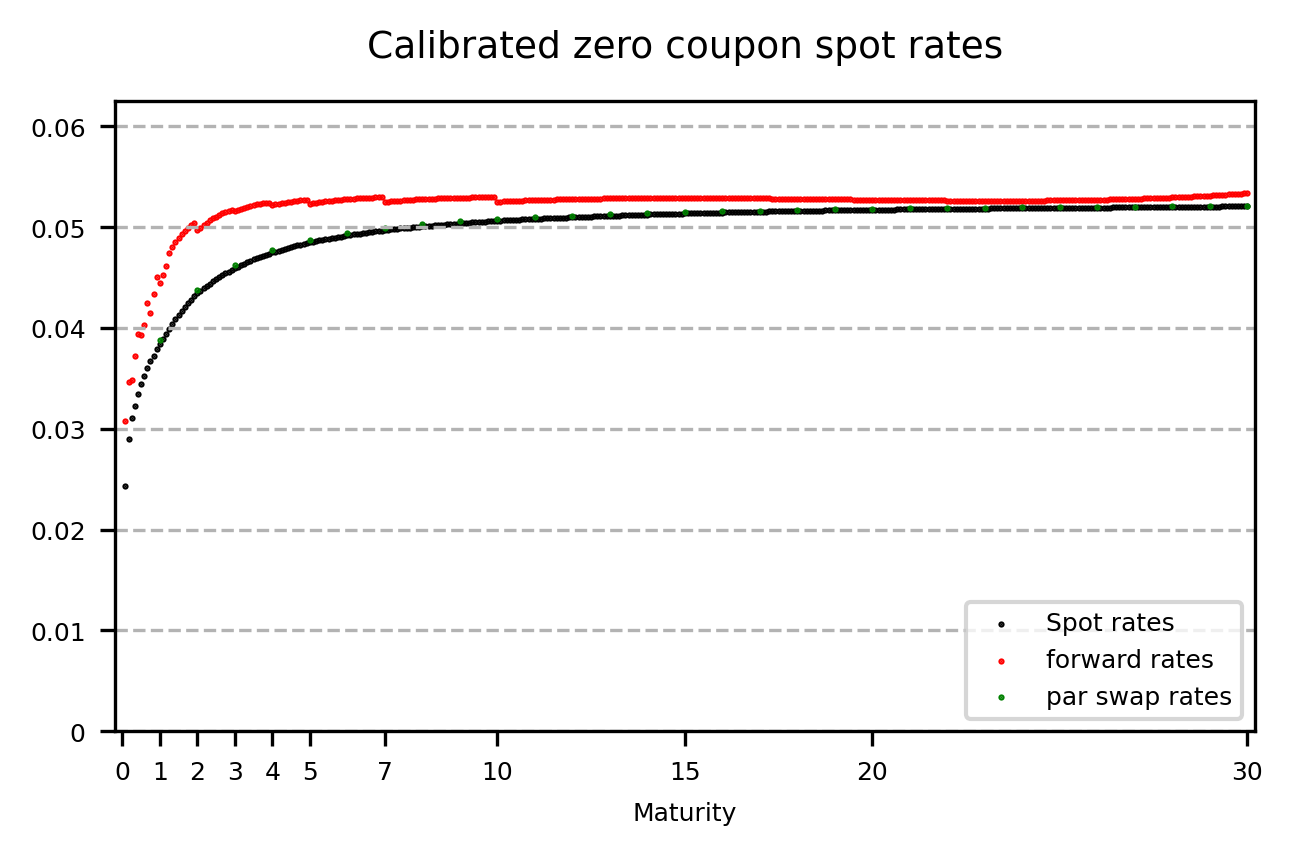

In [13]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.0625])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[1:], R_inter[1:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[1:], f_inter[1:], s = 1, color = 'red', marker = ".",label="forward rates")
p3 = ax.scatter(T_swap, R_swap, s = 1, color = 'green', marker = ".",label="par swap rates")
plots = [p1,p2,p3]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)

# fig.savefig("C:/Jacob/Uni_of_CPH/Interest rate derivatives/exam_prep/curve_fit_zcb_fit.pdf")
# plt.show()

In [ ]:
# # DV01 for bumping one point on the spot curve
# idx_bump, swap_dv, bump = 59, 8, 0.0001
# R_bump = R_curve.copy()
# R_bump[idx_bump] += bump
# p_bump = fid.spot_rates_to_zcb(T_curve,R_bump)
# S_swap = 0
# for idx in swap_market[swap_dv]["indices"]:
#     S_swap += 0.5*p_bump[idx]
# R_swap = (1-p_bump[swap_market[swap_dv]["indices"][-1]])/S_swap
# DV01 = (R_swap-swap_market[swap_dv]["rate"])*S_swap
# print(f"DV01 for swap {swap_dv} when bumping spot_rate: {idx_bump} is: {10000*DV01} bps")

# # DV01 for bumping entire the spot curve
# swap_dv, bump = 8, 0.0001
# R_bump = R_curve.copy()
# R_bump += bump*np.ones([len(R_bump)])
# p_bump = fid.spot_rates_to_zcb(T_curve,R_bump)
# S_swap = 0
# for idx in swap_market[swap_dv]["indices"]:
#     S_swap += 0.5*p_bump[idx]
# R_swap = (1-p_bump[swap_market[swap_dv]["indices"][-1]])/S_swap
# DV01 = (R_swap-swap_market[swap_dv]["rate"])*S_swap
# print(f"DV01 for swap {swap_dv} when bumping entire spot curve is: {10000*DV01} bps, S_swap: {S_swap}")

# # DV01 for bumping one of the swaps
# swap_bump, swap_dv, bump = 4, 8, 0.0001
# swap_market_bump = copy.deepcopy(swap_market)
# swap_market_bump[swap_bump]["rate"] += 0.0001
# data_bump = EURIBOR_fixing + fra_market + swap_market_bump
# T_bump, R_bump, data_bump = fid.zcb_curve_fit(data_bump)
# p_bump = fid.spot_rates_to_zcb(T_bump,R_bump)
# S_swap = 0
# for idx in swap_market_bump[swap_dv]["indices"]:
#     S_swap += 0.5*p_bump[idx]
# R_swap = (1-p_bump[swap_market_bump[swap_dv]["indices"][-1]])/S_swap
# DV01 = (R_swap-swap_market[swap_dv]["rate"])*S_swap
# print(f"DV01 for swap {swap_dv} when bumping market rate for: {swap_bump} is: {10000*DV01} bps")



# T_inter = [i*1/12 for i in range(1,12*30)]
# R_inter = fid.interpolate(T_curve,R_curve,T_inter,interpolation_options)
# p_inter = fid.spot_rates_to_zcb(T_inter,R_inter)
# f_inter = fid.zcb_to_forward_rates(T_inter,p_inter,horizon = 0)